In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable, grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
device=torch.device('mps')
torch.manual_seed(0)

In [8]:
transform = transforms.Compose(
	[transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
										download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
											shuffle=True, num_workers=2)

gradloader = torch.utils.data.DataLoader(trainset, batch_size=4,
											shuffle=False, num_workers=2) #to get the gradient for each epoch

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
										download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
										shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
			'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

print(len(trainloader))

URLError: <urlopen error [Errno 61] Connection refused>

In [3]:
class Net(nn.Module):
	def __init__(self):
		super(Net, self).__init__()
		self.conv1 = nn.Conv2d(3, 6, 5)
		self.pool = nn.MaxPool2d(2, 2)
		self.conv2 = nn.Conv2d(6, 16, 5)
		self.fc1 = nn.Linear(16 * 5 * 5, 120)
		self.fc2 = nn.Linear(120, 84)
		self.fc3 = nn.Linear(84, 10)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = x.view(-1, 16 * 5 * 5)
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x

In [4]:
n_epoch = 2
print(len(trainloader))
net = Net()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
start = time.time()
n_samples = len(trainloader)
grad_norm_epoch = [0 for i in range(n_epoch)]
full_loss_epoch = [0 for i in range(n_epoch)]

for epoch in range(n_epoch):  # loop over the dataset multiple times
	#Compute full gradient and full loss function
	running_loss = 0.0
	net.zero_grad()
	for i, data in enumerate(gradloader, 0):
		inputs, labels = data
		inputs, labels = Variable(inputs), Variable(labels)
		outputs = net(inputs)
		loss_grad = criterion(outputs, labels)
		loss_grad.backward() # compute gradients
		full_loss_epoch[epoch] += loss_grad.data[0]

	#Compute epoch grad and epoch loss
	#Compute grad : see the 'clip_grad_norm' PyTorch function
	for para in net.parameters():
		grad_norm_epoch[epoch] += para.grad.data.norm(2)**2 #take the (norm2)**2 of parameter tensorFloat
	grad_norm_epoch[epoch] = (1./n_samples) * np.sqrt(grad_norm_epoch[epoch])
	full_loss_epoch[epoch] *= (1./n_samples)

	for i, data in enumerate(trainloader, 0):
		# get the inputs & wrap them in Variable
		inputs, labels = data
		inputs, labels = Variable(inputs), Variable(labels)
		# forward + backward + optimize
		net.zero_grad()
		outputs = net(inputs)
		loss = criterion(outputs, labels)
		loss.backward() # compute gradients
		for f in net.parameters():
			f.data.sub_(f.grad.data * learning_rate)

		# print statistics
		running_loss += loss.data[0]
		if i % 2500 == 2499:    # print every 2000 mini-batches
			print('[%d, %5d] loss: %.3f' %
					(epoch + 1, i + 1, running_loss / 2500))
			running_loss = 0.0

end = time.time()
print('time is : ', end - start)
print('Finished Training')

12500
[1,  2500] loss: 2.129
[1,  5000] loss: 1.775
[1,  7500] loss: 1.609
[1, 10000] loss: 1.521
[1, 12500] loss: 1.462
[2,  2500] loss: 1.407
[2,  5000] loss: 1.362
[2,  7500] loss: 1.341
[2, 10000] loss: 1.323
[2, 12500] loss: 1.302
time is :  300.3443639278412
Finished Training


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

GroundTruth:    cat  ship  ship plane
Predicted:   frog   car  ship plane
Accuracy of the network on the 10000 test images: 55 %
Accuracy of plane : 58 %
Accuracy of   car : 78 %
Accuracy of  bird : 44 %
Accuracy of   cat : 40 %
Accuracy of  deer : 40 %
Accuracy of   dog : 34 %
Accuracy of  frog : 63 %
Accuracy of horse : 59 %
Accuracy of  ship : 76 %
Accuracy of truck : 54 %


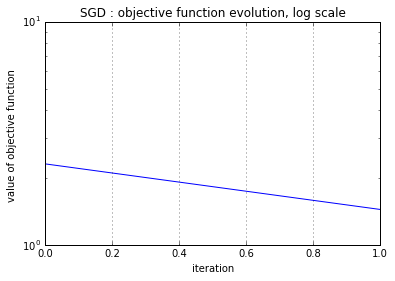

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


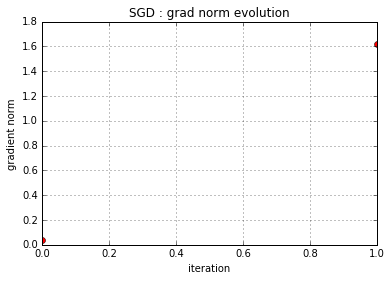

In [7]:
epoch_abs = [i for i in range(n_epoch)]
plt.plot(epoch_abs, full_loss_epoch)
plt.xlabel('iteration')
plt.ylabel('value of objective function ')
plt.title('SGD : objective function evolution, log scale')
plt.yscale('log')
plt.grid()
plt.show()

plt.plot(epoch_abs, grad_norm_epoch, 'ro')
plt.xlabel('iteration')
plt.ylabel('gradient norm')
plt.title('SGD : grad norm evolution')
plt.grid()
plt.legend(loc=1)
plt.show()